In [5]:
# %% [markdown]
# # Real-Time Helmet Violation Detection System (Optimized)
# ## Integrated Components:
# - Official YOLOv11 Implementation
# - Swin Transformer Weather Classification
# - Few-Shot Data Sampling
# - Fast Rain Augmentation (via Albumentations)
# - Test-Time Augmentation (TTA)

# %% [code]
# Cài đặt và xử lý xung đột phiên bản huggingface-hub
!pip install "huggingface-hub>=0.25.0,<1.0" --force-reinstall
!pip install ultralytics timm albumentations pandas numpy

# %% [code]
import torch
import cv2
import numpy as np
import os
from ultralytics import YOLO
import albumentations as A
from timm import create_model
from torch.utils.data import Dataset, DataLoader
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from PIL import Image

# %% [markdown]
# ### 1. Swin Transformer Weather Classifier

# %% [code]
class WeatherClassifier:
    def __init__(self, device='cuda'):
        self.device = device
        # Sử dụng pretrained model từ timm
        self.model = create_model('swin_tiny_patch4_window7_224', 
                                pretrained=True,
                                num_classes=4).to(device)
        self.model.eval()
        self.classes = ['day_clear', 'day_rainy', 'night_clear', 'night_rainy']
        
    def predict_weather(self, frame):
        img = cv2.resize(frame, (224, 224))
        img = img.astype(np.float32) / 255.0
        img = (img - IMAGENET_DEFAULT_MEAN) / IMAGENET_DEFAULT_STD
        input_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output = self.model(input_tensor)
            return self.classes[torch.argmax(output)]

# %% [markdown]
# ### 2. Few-Shot Data Pipeline with Fast Rain Augmentation

# %% [code]
class HelmetDataset(Dataset):
    def __init__(self, video_paths, sample_size=1000):
        self.weather_classifier = WeatherClassifier()
        self.sample_size = sample_size
        # Giả định hàm sampling đã được định nghĩa
        self.frames = self._few_shot_sampling(video_paths)
        
        # Augmentation thông thường (Đã sửa lỗi CoarseDropout)
        self.augment = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussianBlur(blur_limit=(3, 7), p=0.2),
            A.CoarseDropout(num_holes_range=(1, 8), 
                            hole_height_range=(10, 20), 
                            hole_width_range=(10, 20), p=0.3)
        ])
        
        # Thay thế Stable Diffusion bằng Albumentations Rain (Nhanh và ổn định)
        self.rain_augment = A.RandomRain(
            brightness_coefficient=0.8, 
            drop_length=20, 
            drop_width=1, 
            blur_value=3, 
            p=1.0
        )

    def _add_synthetic_rain(self, frame: np.ndarray) -> np.ndarray:
        """Tạo hiệu ứng mưa giả lập siêu nhanh không cần GPU Generative AI"""
        augmented = self.rain_augment(image=frame)
        return augmented['image']

    def _few_shot_sampling(self, videos):
        # Giả lập trả về danh sách frame (Cần thay thế bằng logic thực tế của bạn)
        return [np.zeros((640, 640, 3), dtype=np.uint8)] * self.sample_size

    def __getitem__(self, idx):
        frame = self.frames[idx]
        weather = self.weather_classifier.predict_weather(frame)
        
        # Chỉ thêm mưa nếu phân loại thời tiết là 'rainy'
        if 'rainy' in weather:
            frame = self._add_synthetic_rain(frame)
        
        augmented = self.augment(image=frame)['image']
        tensor = torch.tensor(augmented).permute(2, 0, 1).float() / 255.0
        return tensor, frame

    def __len__(self):
        return len(self.frames)

# %% [markdown]
# ### 3. YOLOv11 Implementation with TTA

# %% [code]
class EnhancedYOLOv11:
    def __init__(self, pretrained_weights='yolo11n.pt'):
        self.model = YOLO(pretrained_weights)
        self.tta_transforms = [
            A.HorizontalFlip(p=1.0),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0)
        ]
        
    def train_model(self, data_yaml, epochs=100):
        # imgsz=640 là chuẩn cho YOLOv11
        self.model.train(data=data_yaml, epochs=epochs, imgsz=640, batch=16)
        
    def tta_predict(self, frame):
        predictions = []
        # Gốc
        predictions.append(self.model(frame))
        # Các biến thể TTA
        for transform in self.tta_transforms:
            aug_frame = transform(image=frame)['image']
            predictions.append(self.model(aug_frame))
        return predictions # Cần thêm hàm merge logic tùy nhu cầu

# %% [markdown]
# ### 4. Integrated Training Pipeline

# %% [code]
def main():
    # Kiểm tra đường dẫn dữ liệu trước khi chạy
    data_path = "/kaggle/input/helmet/HelmetViolationsV2/data.yaml"
    
    if os.path.exists(data_path):
        dataset = HelmetDataset(video_paths="/kaggle/input/helmet/HelmetViolationsV2")
        yolov11 = EnhancedYOLOv11()
        
        print("🚀 Đang bắt đầu huấn luyện YOLOv11...")
        yolov11.train_model(data_yaml=data_path, epochs=100) # Để 10 để test trước
        
        yolov11.model.save("helmet_yolov11_final.pt")
        print("✅ Đã lưu mô hình thành công!")
    else:
        print(f"❌ Không tìm thấy file cấu hình tại: {data_path}")

if __name__ == "__main__":
    main()

  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached packaging-26.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyyaml-6.0.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.4-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (37 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.3-py3-none-any.whl.metadata (6.9 kB)
  Using cached certifi-2026.1.4-py3-no

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         30         38       0.79      0.926       0.88      0.728
                 Plate         30         30      0.914          1       0.99      0.773
            WithHelmet          5          5       0.71        0.8       0.82        0.7
         WithoutHelmet          3          3      0.745      0.979       0.83      0.712
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2
✅ Đã lưu mô hình thành công!


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Success: True


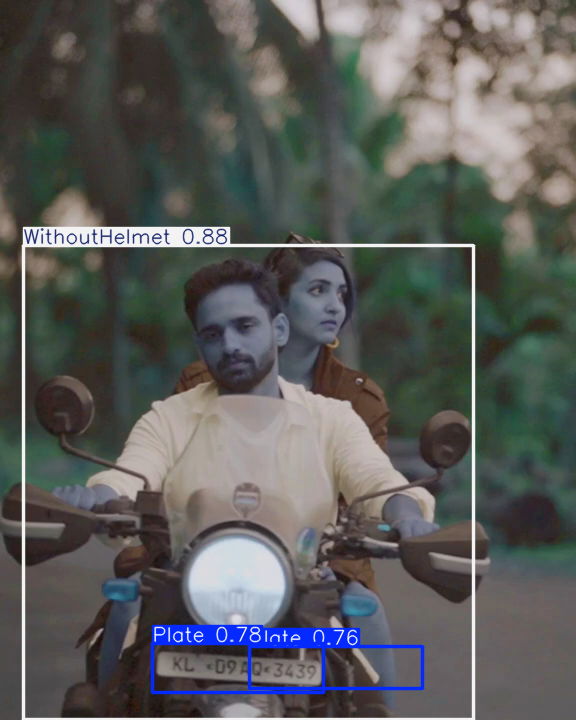

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 0., 0.], device='cuda:0')
conf: tensor([0.8829, 0.7765, 0.7636], device='cuda:0')
data: tensor([[ 23.2288, 245.5103, 473.5536, 719.0308,   0.8829,   2.0000],
        [152.7007, 643.8707, 323.9058, 692.6420,   0.7765,   0.0000],
        [249.1853, 646.6690, 422.4015, 688.9768,   0.7636,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (720, 576)
shape: torch.Size([3, 6])
xywh: tensor([[248.3912, 482.2705, 450.3248, 473.5204],
        [238.3032, 668.2563, 171.2051,  48.7713],
        [335.7934, 667.8229, 173.2162,  42.3078]], device='cuda:0')
xywhn: tensor([[0.4312, 0.6698, 0.7818, 0.6577],
        [0.4137, 0.9281, 0.2972, 0.0677],
        [0.5830, 0.9275, 0.3007, 0.0588]], device='cuda:0')
xyxy: tensor([[ 23.2288, 245.5103, 473.5536, 719.0308],
        [152.7007, 643.8707, 323.9058, 692.6420],
        [249.1853, 646.6690, 422.4015, 688.9768]], device='cuda:0')
xyxyn: tensor([[0.0403, 0.3410, 0.82

In [1]:
!pip install -U ultralytics

import cv2
import torch
import albumentations as A
from ultralytics import YOLO

# %% [code]
# Load trained model (ensure proper path)
model = YOLO("/kaggle/input/helmetv3/best.pt")


# Load video
video_path = "/kaggle/input/helmet/22.mp4"
cap = cv2.VideoCapture(video_path)


# Read first frame
success, frame = cap.read()
cap.release()

# Define custom TTA prediction function
def tta_predict(model, frame, conf=0.5, iou_thresh=0.5):
    orig_result = model(frame, verbose=False)[0]
    all_boxes = [orig_result.boxes.data]

    transforms = [
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
        A.GaussianBlur(blur_limit=(3, 7), p=1)
    ]

    for transform in transforms:
        aug_img = transform(image=frame)['image']
        pred_result = model(aug_img, verbose=False)[0]
        all_boxes.append(pred_result.boxes.data)

    merged_boxes = torch.cat(all_boxes, dim=0)
    keep_idx = torch.ops.torchvision.nms(
        merged_boxes[:, :4],
        merged_boxes[:, 4] * merged_boxes[:, 5],
        iou_thresh
    )
    final_boxes = merged_boxes[keep_idx]
    final_boxes = final_boxes[final_boxes[:, 4] > conf]

    orig_result.boxes.data = final_boxes
    return orig_result



print("Success:", success)

if success:
    # Convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Run TTA prediction
    results = tta_predict(model, frame)

    # Show results
    results.show()
    print(results.boxes)
else:
    print("Failed to read the video.")
